# Support Vector Machines (SVMs)

<hr style="border:2px solid gray">

# Outline <a id='index'></a>
1. [Useful sklearn Features](#sklearn)
1. [Introduction to SVMs](#SVM_intro)
1. [Linear SVM Classifiers](#linear_SVM)
1. [Nonlinear SVM Classifiers](#nonlinear_SVM)
1. [Kernel Tricks](#kernel)
1. [SVM Regressors](#SVR)
1. [Appendices](#appendix)
    - [A: Mathematics of SVM Classifiers (SVCs)](#SVM_app)
    - [B: Mathematics of Kernel Tricks](#kernel_app)
    - [C: A Worked Kernel Trick Example](#kernel_ex_app)
    - [D: Mathematics of SVM Regressors (SVRs)](#SVR_app) 


<hr style="border:2px solid gray">

# Useful `sklearn` Features [^](#index) <a id='sklearn'></a>

The majority of this notebook will focus on Support Vector Machines, however this initial section will identify useful `sklearn` features you may need to use.


## The `sklearn` Preprocessor

We have previously used and discussed `sklearn.preprocessing` in ML Basics 1. As a reminder, preprocessing can take raw data and transform it into a form better suited for training a model. In this section we will reiterate some key features, as well as introduce new uses:

- We can transform the **range** of the data, both linearly and non-linearly. Many ML approaches expect the training data to fall in a given range (say between -1 and 1). Instances far outside this expected range may unduly skew the learning process. 
    - An example of altering the range is **normalising** the dataset. <br><br>
    

- We can **encode** categorical features. ML algorithms typically require numerical values for all features. However, many datasets may have features that are not numerical values but instead categories like 'Male' or 'Likes Horror Films'. `sklearn.preprocessing` has functions that will transform these group categories into numbers.
    - An example of this is [**One-Hot Encoding**](https://www.educative.io/blog/one-hot-encoding), where for each categorical feature we add new features corresponding to each possible category, with possible values of 0 or 1.  <br><br>

- We can turn a continuous variable into a series of categories - this is called **discretisation**.
    - For example, we could convert our data to a binary choice (such as falling above or below as certain threshold) <br><br>

- We can generate **inputs for missing values**. As discussed in ML Basics 1, this process should be performed with care. <br><br>

- We can **generate polynomial features**. 

For more information, please read the detailed sklearn [documentation](https://scikit-learn.org/stable/modules/preprocessing.html).


**Pipelines** (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn-pipeline-pipeline)) enable you to sequentially run a list of different transformers followed by a final estimator. This was discussed previously in ML Basics 1.


<div style="background-color:#000">

### Exercise

Read through the documentation linked above. Pick out 3 preprocessors and code short examples of their use. Try the following options:
- One should involve encoding categorical features
- One should involve creating polynomial features
- The final preprocessor can be your choice (for example, data imputation or scaling)

## Saving Models

Some models can take a long time to train, and thus it is often beneficial to save the trained model so you can use it again later without needing to redo the training process. This can most easily be achieved with the [**pickle**](https://docs.python.org/3/library/pickle.html) package.

In the example below, we would like to save a k-Nearest Neighbours model trained on the iris dataset.

In [1]:
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

iris=load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.2) 


neighbors = 12
weights = "uniform"
iris_knn = KNeighborsClassifier(n_neighbors=neighbors,weights=weights)
iris_knn.fit(X_train,y_train)
pred = iris_knn.predict(X_test)

print(accuracy_score(y_test, pred))

# We can now store our model

import pickle as pk

filename = 'model'
outfile = open(filename,'wb')
pk.dump(iris_knn,outfile)
outfile.close()


0.9333333333333333


Now that we have saved this model, let's read it back in (to show that we can). 

When working in a Jupyter Notebook the code cell below is not needed, but we are pretending that this is a separate program being run at a different time, to illustrate how we would load a model in practice.

In [2]:
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle as pk

iris=load_iris()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.5) #different test selection

filename='model'
infile=open(filename,'rb')
knn=pk.load(infile)
pred=knn.predict(X_test)

print(accuracy_score(y_test, pred))

1.0


<div style="background-color:#000">

### (Quick) Exercise

Rerun the two cells above, but restart the kernel after the first cell has run. This is just to show that the method does work.

<hr style="border:2px solid gray">

# Support vector machines [^](#index) <a id='SVM_intro'></a>

Support Vector Machines (SVMs) are historically some of the most commonly used ML techiques, although in physics they are less popular more recently. They can be in used in both classification (SVCs) and regression problems, but they are more often used in classification in High Energy Physics. [HoML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is really very clear in describing these and is very recommended.

We will start by considering classification using support vector machines, and then we will briefly discuss regression.

## SVM classification

<!-- Imagine we have an $N$-dimensional feature space, with 2 different classes. If we want to separate these classes, we might try to draw a boundary between them - for example, in a 2D example we might try to draw a straight line that separates the two classes. 

Below, we have taken two of the classes from the Iris dataset you saw in ML Basics 2, *iris versicolor* and *iris setosa*, and plotted the petal length against the petal width. We can see these two classes are linearly separable in these variables, i.e. we can draw a straight line on our plot to separate them. The dotted and dashed lines illustrate possible separation lines.

However, these possible separators are not necessarily **robust**; it is easy to imagine additional irises in either class crossing these classification lines, due to the spread of possible values. Instead, we want to optimise the choice of separation line to make sure we are robust against outliers and can generalise well to unseen data.

<img src='imgs_svm/arbitrary_separators_example.png' width=600 align='center'/>

*Example possible separating lines for two of the classes in the Iris dataset. While these lines do separate the two classes, they are not robust against outliers.*

 -->

Imagine we have some $N$-dimensional feature space, with 2 different classes. In order to separate these classes, we need to find some $N-1$-dimensional **hyperplane** (a generalisation of a straight line in 2D, or a plane in 3D) that lies between the two classes. Support vector machines aim to find the best possible hyperplane to separate our classes.

The aim is to create well-defined boundaries between classes, such that a data point with a particular set of characteristics is classified with maximum accuracy, so an SVM aims to find the hyperplane with **maximum separation** between the categories. We refer to the distance between the two categories as the **margin**, and the optimal hyperplane is the **maximum-margin hyperplane**. In general, we try to avoid having training data points inside the margin, but how strict we are with this depends on our choice of regularisation, which we will discuss later.

The choice of the maximum-margin hyperplane depends only on the points in each class that are closest to the hyperplane, which are referred to as **support vectors** and are why this algorithm is called the support vector machine.

SVMs are particularly useful when you have moderate volumes of data (up to around $10^5$ datapoints). 

The mathematics behind SVM can be seen in Appendix A: [Mathematics of SVM Classifiers (SVCs)](#SVM_app).

We will now see some more details and experiment with linear SVM classifiers.

<hr style="border:2px solid gray">

# Linear SVM Classifiers [^](#index) <a id='linear_SVM'></a>

Let's consider two linearly-seperable datasets. 

For this example we will take a subset of the iris dataset. We will only be interested in two types of iris (the *setosa* or the *versicolor* i.e. category 0 or 1). The only features we will investigate are petal length and petal width.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:,(2,3)]# petal length, petal width. (this slice is equivalent to X = iris["data"][:,2:4])
y = iris["target"]
setosa_or_versicolor = (y == 0) | (y == 1) # we only want y-values of 0 or 1. | is the bitwise OR operator.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Below we plot both our data and two lines can separate the instances. As we will see, just because a line separates our data, it is not necessarily the optimal separator.

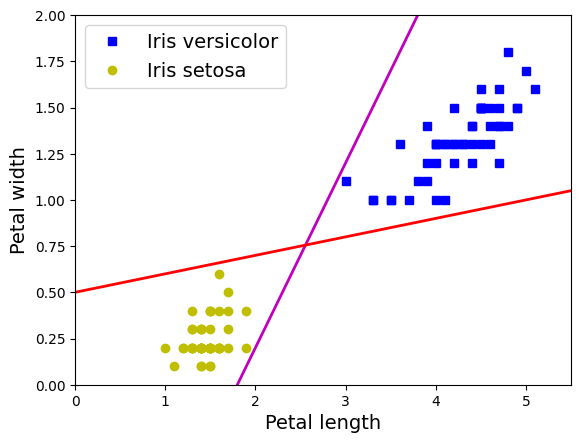

In [4]:
x0 = np.linspace(0, 5.5, 200)

pred_1 = x0 - 1.8
pred_2 = 0.1 * x0 + 0.5

plt.plot(x0, pred_1, "m-", linewidth=2)
plt.plot(x0, pred_2, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Both of these lines separate the two different iris types, however they are very close to the category limits -  it is very possible that more data of either sort of iris will just cross the boundary and be wrongly classified. SVM helps solve this issue by trying to find the line that provides the **greatest separation**.

In sklearn, SVM takes the parameters `C` and `kernel`. In general, `C` is a hyperparameter of the algorithm and is referred to as the regularisation parameter, and must be a strictly positive float (although it can be very large or very close to 0). Decreasing `C` corresponds to more regularisation. This is discussed more later, but for now we set `C` to be a very large number, such that it is effectively infinite. The default value of `C` is 1. 

We will discuss `kernel` in detail later, when we talk about non-linear SVM. For now, we will just set `kernel = linear`.

In [5]:
from sklearn.svm import SVC

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=100000000.0)
svm_clf.fit(X, y)

,C,100000000.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


We can call `svm_clf.coef_[0]` and `svm_clf.intercept_[0]` to find the array of fitted weights ($\mathbf{w}$) and the bias ($b$) used to define the hyperplane. Coordinates $\boldsymbol{X}$ on the decision boundary are those that obey $\sum{(w_i X_i)} +b =0$, which can also be expressed in vector form as $\boldsymbol{w}^T  \boldsymbol{X} + b =0$. In our 2D example, this means the equation of our boundary line is given by $w_0 X_0+w_1 X_1 + b =0$, rearranging to give $X_1 = -\frac{w_0}{w_1}  X_0 - \frac{b}{w_1}$.

The actual support vectors can be obtained by calling `svm_clf.support_vectors_`.

To find the margins of our line (i.e. to find the equation of the lines that pass through the support vectors), we add $\pm \frac{1}{w_1}$.

We can use this equation to plot our results. We will also define a short function to plot the SVC line and margin:

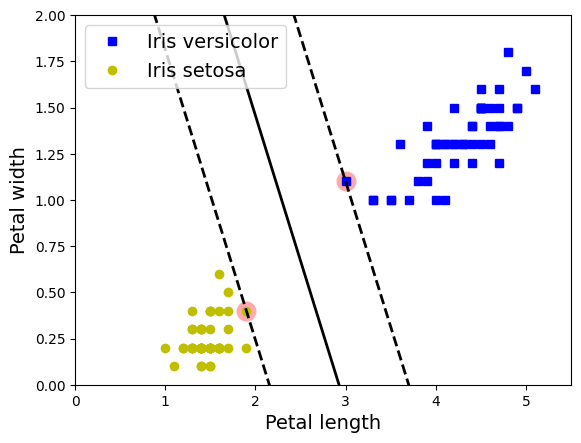

In [6]:
def plot_svc(clf, xmin, xmax, sv = True):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1]*x0 - b/w[1]
    margin = 1/w[1]

    boundary_up = decision_boundary + margin
    boundary_down = decision_boundary - margin

    svs = clf.support_vectors_
    plt.plot(x0,decision_boundary, "k-",linewidth = 2)
    plt.plot(x0, boundary_up, "k--", linewidth = 2)
    plt.plot(x0, boundary_down, "k--", linewidth = 2)
    if sv:
        plt.scatter(svs[:,0], svs[:,1], s = 180, facecolors='#FFAAAA')

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)


plot_svc(svm_clf, 0, 5.5)
plt.axis([0, 5.5, 0, 2])

plt.show()

We can see that the SVM has indeed chosen the line that has the greatest separation. The two marked points are the nearest two points to the dividing line, and these are the actual support vectors. Any points further from the chosen line (hyperplane in general) than the support vectors do not affect the chosen line.

SVM can be very sensitive to feature scale. In the example below (taken from **{HoML}**) you can see the difference the preprocessor scaling can make.

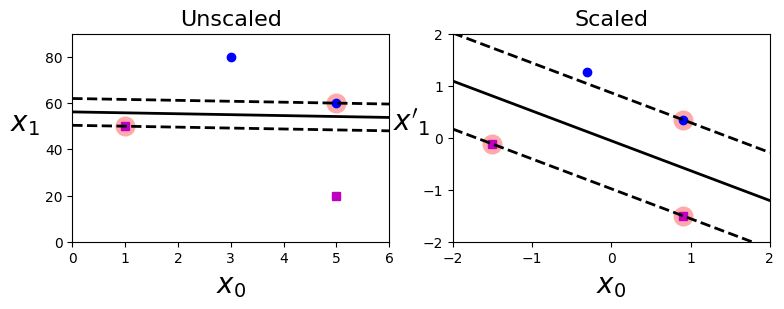

In [7]:
# Arbitrary Data

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

svm_clf = SVC(kernel="linear")
svm_clf.fit(Xs, ys)
    
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")

plot_svc(svm_clf, 0, 6)

plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# Now use the sklearn preprocessor to scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)

svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")

plot_svc(svm_clf, -2, 2)

plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

We can see that the model with scaled data has a much better margin between the two classes.

## Soft Margin Classification

Of course, it may not always be possible to construct a maximum-margin hyperplane such that all of the data points are outside of the margin. This means that the data is not linearly separable, and results in so-called **margin violations** where training data points are inside the margin. You may also find that even if your data is linearly separable, it may be with a very small margin, which is not very resistant to outliers. To tackle such cases, the soft-margin condition is introduced. 

Instead, we must adopt the so-called **soft margin** condition: we allow **margin violations**, i.e. allowing points to lie inside the margin, but we penalise a model with training points in the margin depending on how far into the margin those training points are. The scale of this penalty is controlled by the regularisation parameter `C`. This is equivalent to the **hinge loss** we mentioned in ML Basics 2.

In the code cell below, we introduce an outlier to our IRIS dataset and then train an SVM with `C = 1`. We see now that we have margin violations, although the outlier is still on the wrong side of the boundary entirely.

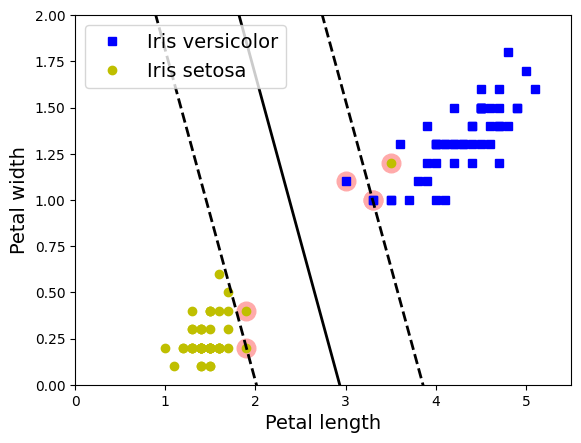

In [8]:
X_mod=X
X_mod=np.append(X,[[3.5,1.2]], axis=0) # Add one new outlier
y_mod=np.append(y,0) # Assume new point is an iris setosa

#fit the new model and plot
svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_mod, y_mod)

plt.plot(X_mod[:, 0][y_mod==1], X_mod[:, 1][y_mod==1], "bs", label="Iris versicolor")
plt.plot(X_mod[:, 0][y_mod==0], X_mod[:, 1][y_mod==0], "yo", label="Iris setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

plot_svc(svm_clf, 0, 5.5)

plt.axis([0, 5.5, 0, 2])

plt.show()

We can see that the data is no longer linearly separable and that there is now a margin violation. 

By allowing training points inside the margin, we are performing **soft margin classification**. The choice of the value of `C` determines how much we allow training points inside the margin; low values of `C` allow greater margin violations, while high values minimise margin violations. Very high values of `C` corresponds to the hard margin classification problem i.e. no margin violations allowed.


<div style="background-color:#000">

### Exercise

Investigate how varying `C` affects our model. Take the code above, add a few more "outliers" and then plot the results for `C` going from small values (say 0.0001) to quite large values (say 1000000). Use these plots to help to understand the behaviour.

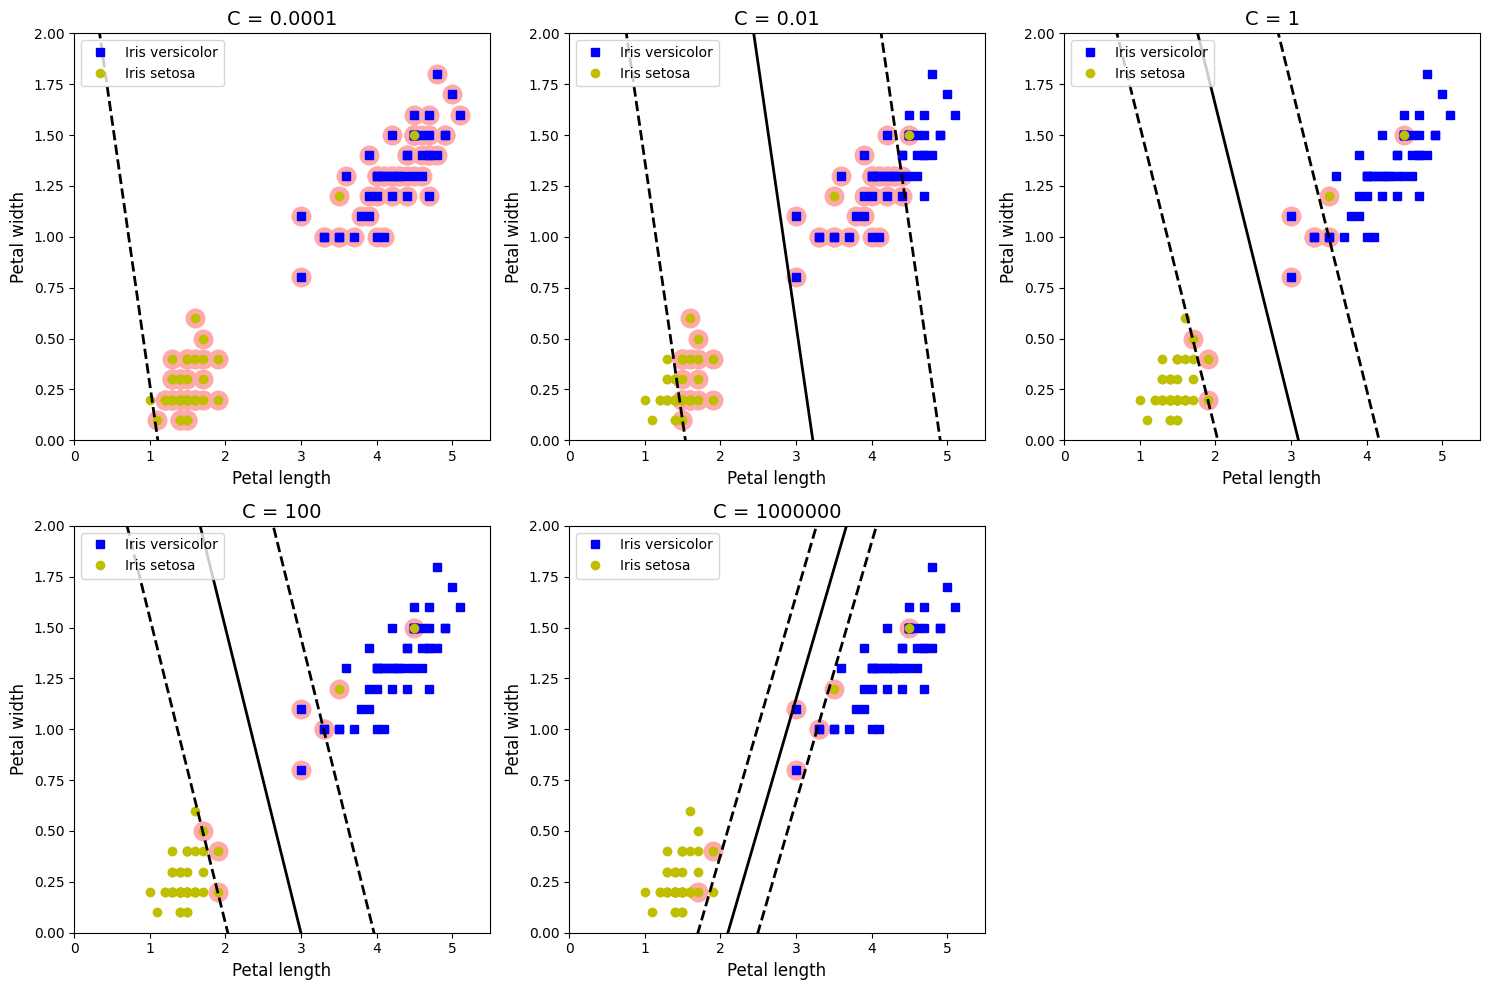

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Add outliers to the dataset
X_mod = np.append(X, [[3.5, 1.2], [4.5, 1.5], [3.0, 0.8]], axis=0)  # Add a few more outliers
y_mod = np.append(y, [0, 0, 1])  # Assign labels to the new points

# Define a range of C values to test
C_values = [0.0001, 0.01, 1, 100, 1000000]

# Loop over each C value and plot the results
plt.figure(figsize=(15, 10))
for i, C in enumerate(C_values, 1):
    svm_clf = SVC(kernel="linear", C=C)
    svm_clf.fit(X_mod, y_mod)

    plt.subplot(2, 3, i)
    plt.plot(X_mod[:, 0][y_mod == 1], X_mod[:, 1][y_mod == 1], "bs", label="Iris versicolor")
    plt.plot(X_mod[:, 0][y_mod == 0], X_mod[:, 1][y_mod == 0], "yo", label="Iris setosa")
    plt.xlabel("Petal length", fontsize=12)
    plt.ylabel("Petal width", fontsize=12)
    plt.title(f"C = {C}", fontsize=14)
    plt.legend(loc="upper left", fontsize=10)

    # Plot the decision boundary and margins
    plot_svc(svm_clf, 0, 5.5)
    plt.axis([0, 5.5, 0, 2])

plt.tight_layout()
plt.show()

<hr style="border:2px solid gray">

# Nonlinear SVM Classifiers [^](#index) <a id='nonlinear_SVM'></a>

Not all problems involve datasets which are linearly separable. However, many of these datasets do become linearly separable if we **add features**, for example higher-order polynomial terms (as we did with nonlinear regression in ML Basics 1). 

A simple example is shown below, generated using sklearn's `make_circles`. We have two features, $X_1$ and $X_2$, and two different classes. These classes are in two rings with radii of 1 and 0.4 respectively, and with some Gaussian noise with a standard deviation of 0.1. This data is clearly not linearly separable in our current features:

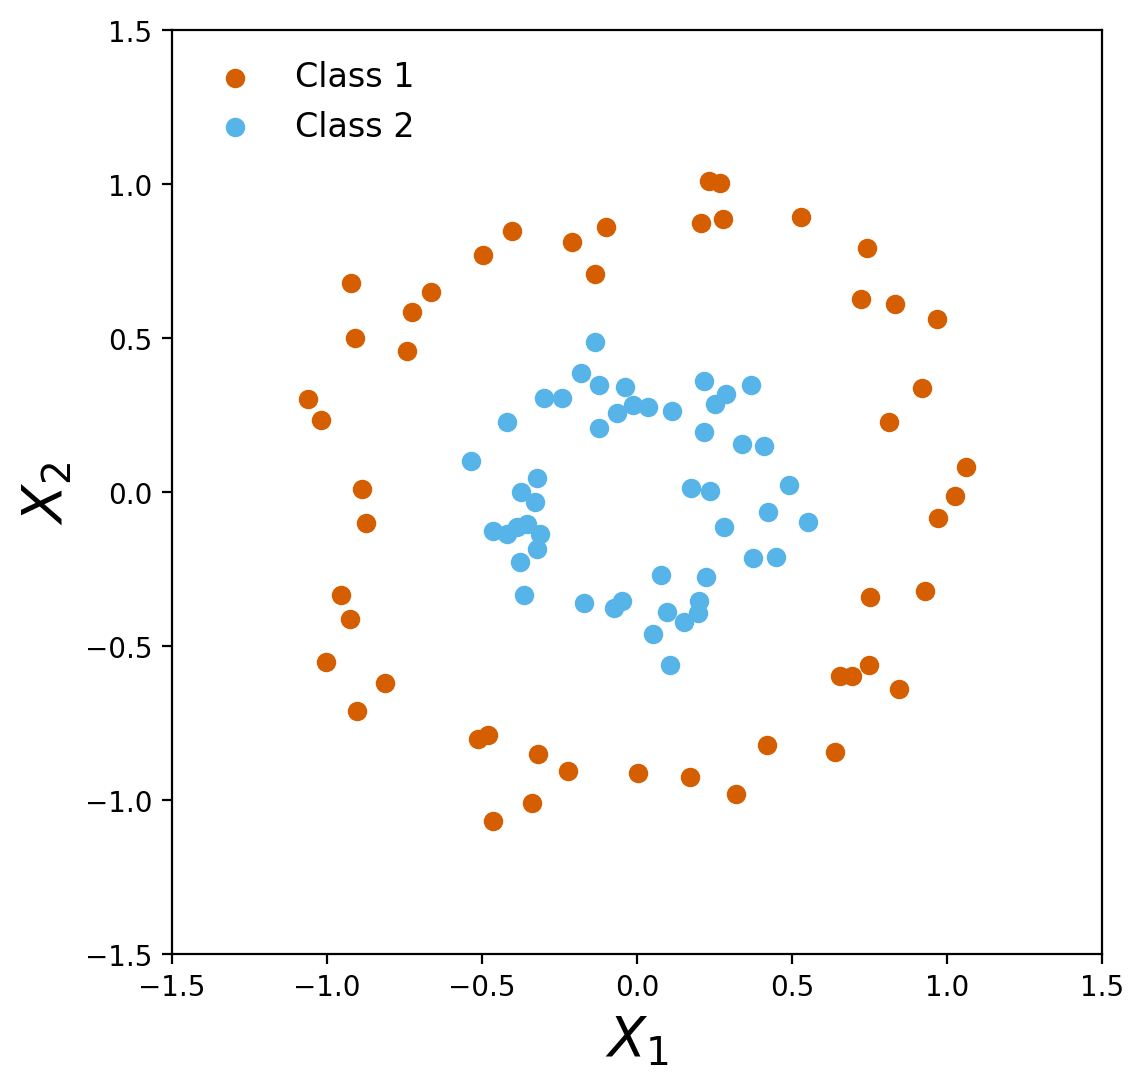

In [11]:
from sklearn.datasets import make_circles

cols = ['#D55E00','#56B4E9'] # Define some nice colours

X, y = make_circles(factor = 0.4, noise = 0.1, random_state = 1)

fig = plt.figure(figsize=(6,6),dpi = 200)
ax = fig.add_subplot(111)
ax.scatter(X[:,0][y==0], X[:,1][y==0], color = cols[0], label = 'Class 1')
ax.scatter(X[:,0][y==1], X[:,1][y==1], color = cols[1], label = 'Class 2')
ax.set_xlabel(r'$X_1$', fontsize = 20)
ax.set_ylabel(r'$X_2$', fontsize = 20)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.legend(loc='upper left', fontsize = 12, framealpha=0)

While this isn't separable in our current points, this could quite easily be separable if we added a feature corresponding to radius, i.e. $X_3 = \sqrt{X_1^2 + X_2^2}$. To show this, we will train SVMs on the original data and one where we have appended this new feature, and visualise the decision boundary on the data. 

We will make use of a few useful utilities in sklearn: `Pipeline`, and `DecisionBoundaryDisplay`. These are as follows:

* `Pipeline`: allows you to chain multiple operations together into a single model, e.g. including your preprocessing alongside your model easily

* `DecisionBoundaryDisplay`: a useful class to plot the decision boundary of a model for a 2D dataset

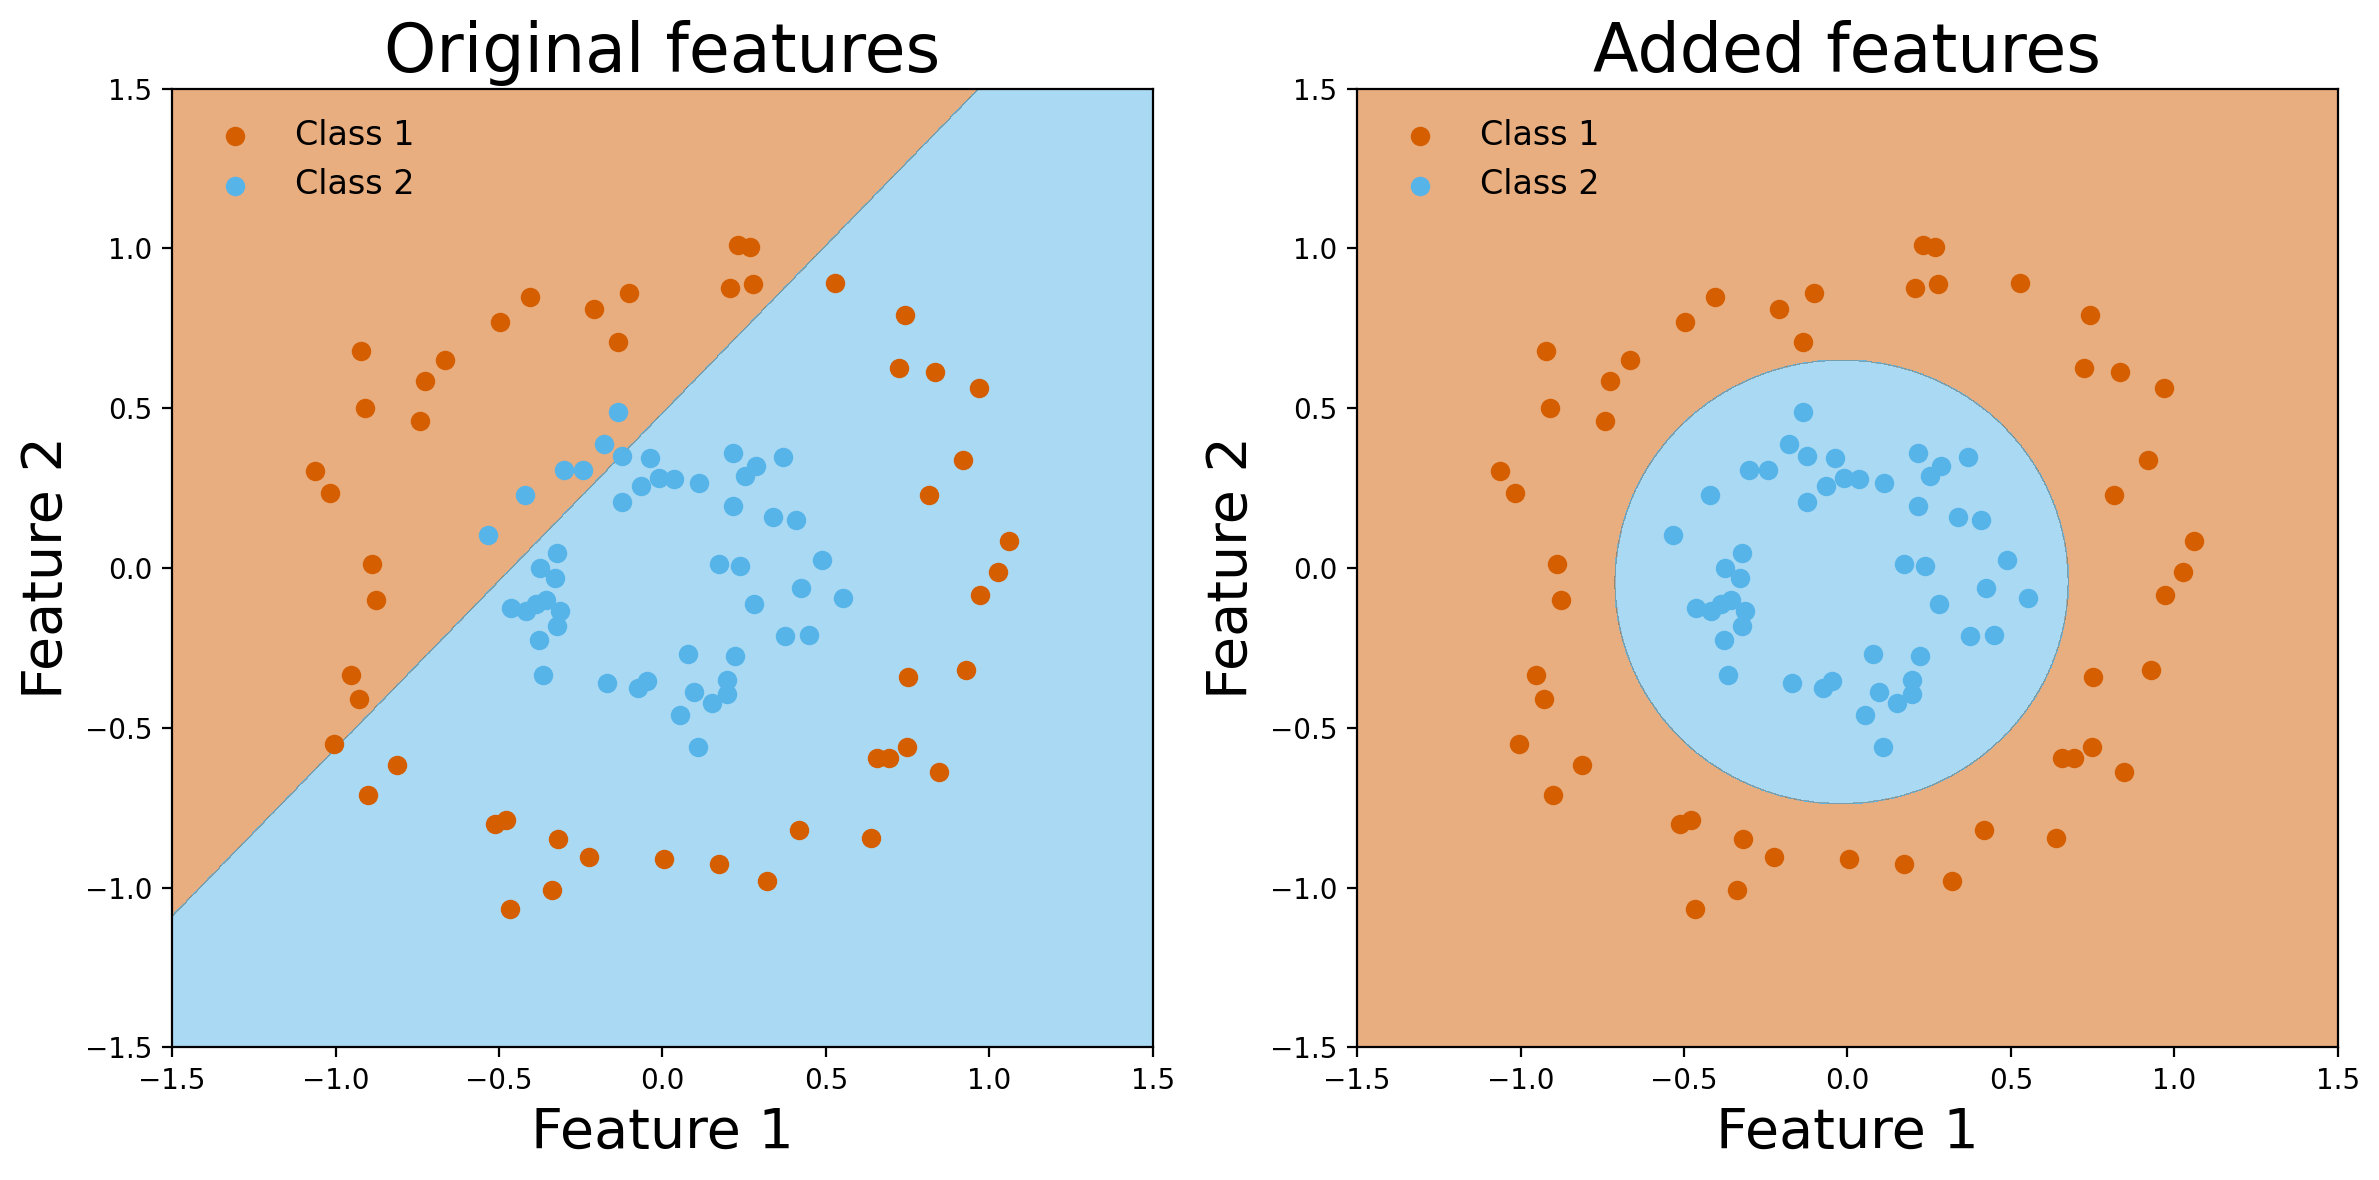

In [13]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# Define a function to find the new feature and append it to our feature list
def append_norm(X):
    return np.concatenate([X, np.linalg.norm(X, axis = 1).reshape(-1,1)], axis = 1)

svm_pre = SVC(kernel = 'linear', C = 10)
# Include our transform in our Pipeline using FunctionTransformer
svm_post = Pipeline([
                    ("new_feat", FunctionTransformer(append_norm)),
                    ("SVC", SVC(kernel = 'linear', C = 10))
                    ])

svm_pre.fit(X, y)
svm_post.fit(X, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), dpi = 200)
for ax, clf, title in [(ax1, svm_pre, 'Original features'), (ax2, svm_post, 'Added features')]:
    DecisionBoundaryDisplay.from_estimator(clf, X, response_method = 'predict',
                                           colors = [cols[0], cols[1], cols[1], cols[1], cols[1]],
                                           alpha = 0.5, 
                                           ax = ax,
                                           grid_resolution=2000)
    ax.scatter(X[:,0][y==0], X[:,1][y==0], color = cols[0], label = 'Class 1')
    ax.scatter(X[:,0][y==1], X[:,1][y==1], color = cols[1], label = 'Class 2')
    ax.set_xlabel('Feature 1',fontsize = 20)
    ax.set_ylabel('Feature 2',fontsize = 20)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.legend(loc='upper left', fontsize = 12, framealpha=0)
    ax.set_title(title, fontsize = 24)

fig.set_tight_layout(True)



We can see quite clearly how well our model with the additional feature performs, in comparison with the original feature set.

## SVM with `make_moons`

We will now examine another famous ML dataset (or rather a way of making data sets) - this is the function in sklearn `make_moons`. 

`make_moons` creates two intertwined data sets which are clearly not lienarly separable, so we will need to add some polynomial features. Below we plot the data set:

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    ax.axis(axes)
    ax.grid(True, which='both')
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20, rotation=0)
    return fig, ax

fig, ax = plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Using sklearn's `Pipeline` function, we can sequentially call all our data transforms, feature additions and the SVM classifier as just one function. The number of polynomial features we would like to add is specified using the degree keyword argument in PolynomialFeatures.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Let's add a pipline that adds polynomial features and scales it.

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="linear", C=1)) # could use LinearSVC(C=10)) as this would be much faster
    ])

polynomial_svm_clf.fit(X, y)

Having created and fit this ML model, we can then plot our results.

In [ ]:
fig, ax = plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
DecisionBoundaryDisplay.from_estimator(polynomial_svm_clf, X, response_method = 'predict',
                                        multiclass_colors = 'brg',
                                        alpha = 0.2, 
                                        ax = ax,
                                        grid_resolution=2000)
ax.set_title('Polynomial feature linear SVM',fontsize = 20)

Not bad at all. Try it with different values of C and it might get even better or worse.

Adding polynomial features is a very useful thing to do, and often can improve performance. However, it can cause a significant increase in the number of features as you go to higher dimensionality, which vastly increases the time required to train our model. Also, as things get more complicated, lower order polynomials no longer work well. 

Fortunately, we have another trick up our sleeve - a **kernel trick**.

<hr style="border:2px solid gray">

# Kernel Tricks [^](#index) <a id='kernel'></a>

So far we have worked with linear SVMs, and managed to deal with data that is not linearly separable by either using a soft margin condition or by adding polynomial features to our data. However, this is not always the best decision; we will present why this is the case, and then talk about how we can get around this with kernel tricks.

## Issues with SVM

In general, data which cannot be linearly separated in $n$ dimensions can be linearly separated in some higher number of dimensions $m$ by an $m - 1$ dimensional hyperplane. We used this technique when we created a quadratic feature in our 1D line exercise. 

In practice, the parameters that describe the hyperplane can be found by calculating a large number of **inner products** in this higher dimensional space.

However, increasing the number of dimensions comes at a cost: we must devote significantly more computational time to find this hyperplane in the new higher dimensional space, because of the number of features we must compute inner products between. The amount of computation scales as $n^2$, so this is not feasible for large datasets.

## How Kernel Tricks can Help

We can actually express all of the inner products in the higher-dimensional space as linear combinations of powers of inner products in the original, lower dimensional space.

This removes the need to perform the actual coordinate transformation: we can obtain the results to the higher-dimensional computations while remaining in our lower-dimensional space, saving computational power.

The **kernel trick** is knowing how to find this linear combination. A **kernel** is a function of inner-products in the original space, that gives results equivalent to doing the calculation in the higher-dimensional space. There are many popular kernels to use, however in this notebook we will just consider polynomial and radial basis function (RBF, also known as Gaussian) kernels.

If we denote our transformation to a higher-dimensional space as $\phi$, then we want to find some kernel function $k$ such that $k(\mathbf{X}_i,\mathbf{X}_j) = \phi(\mathbf{X}_i)^\intercal\cdot\phi(\mathbf{X}_j)$; this way we can skip the transformation and inner product in the higher space, and just evaluate our kernel function.

The mathematical formulation of kernel tricks can be found in Appendix B: [Mathematics of Kernel Tricks](#kernel_app), and a worked example of a kernel trick can be found in the Appendix C: [A Worked Kernel Trick Example](#kernel_ex_app).

Some common examples of kernels include:

* Polynomial: $k(\mathbf{X}_i,\mathbf{X}_j) = (\gamma\mathbf{X}_i^\intercal \cdot \mathbf{X}_j + r)^d$, where $d$ is the order of the polynomial, $\gamma$ is a scale parameter and $r$ is a bias parameter. $d$ = 1 corresponds to the linear case we have seen already.
<br>
    
* Gaussian radial basis function: $k(\mathbf{X}_i,\mathbf{X}_j) = \exp\left(-\gamma||\mathbf{X}_i - \mathbf{X}_j||^2\right)$, where $\gamma$ is a scale parameter and $\gamma$ > 0
<br>
    
* Sigmoid function: $k(\mathbf{X}_i,\mathbf{X}_j) = \tanh(\gamma\mathbf{X}_i^\intercal\cdot\mathbf{X}_j + r)$, where $\gamma$ and $r$ are scale and bias parameters respectively



We will show the SVM syntax using a polynomial kernel for the rings data we saw before:

In [ ]:
X, y = make_circles(factor = 0.4, noise = 0.1, random_state = 1) # Prepare the data again, same random seed

poly_svc = SVC(kernel = 'poly', degree = 2, C = 10) # Degree 2 polynomial, no offset

poly_svc.fit(X, y)

fig = plt.figure(figsize=(6,6), dpi = 200)
ax = fig.add_subplot(111)
DecisionBoundaryDisplay.from_estimator(poly_svc, X, response_method = 'predict',
                                           colors = [cols[0], cols[1], cols[1], cols[1], cols[1]],
                                           alpha = 0.5, 
                                           ax = ax,
                                           grid_resolution=2000)
ax.scatter(X[:,0][y==0], X[:,1][y==0], color = cols[0], label = 'Class 1')
ax.scatter(X[:,0][y==1], X[:,1][y==1], color = cols[1], label = 'Class 2')
ax.set_xlabel(r'$X_1$', fontsize = 20)
ax.set_ylabel(r'$X_2$', fontsize = 20)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.legend(loc='upper left', fontsize = 12, framealpha=0)
fig.tight_layout()

We can see we've achieved a nice decision boundary without needing to think about what kind of features we would need to add! This is another power of kernel tricks, as otherwise you have to come up with what your new features are going to be.

Now, we will work with our `make_moons` data from earlier, as the boundary there is not as trivial as in the `make_circles` case. We first will regenerate the data, and then try using `SVC` with `kernel = 'rbf'` to see how well we can do:

In [ ]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

rbf_kernel_svm = Pipeline([
                           ("scaler", StandardScaler()),
                           ("svc", SVC(kernel = 'rbf'))
                          ])
rbf_kernel_svm.fit(X, y)

fig, ax = plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
DecisionBoundaryDisplay.from_estimator(rbf_kernel_svm, X, response_method = 'predict',
                                        multiclass_colors = 'brg',
                                        alpha = 0.2, 
                                        ax = ax,
                                        grid_resolution=2000)
ax.set_title('RBF kernel SVM',fontsize = 20)




Using default parameters we're doing ok-ish, but clearly there is scope to improve on this performance. 

<div style="background-color:#000">

### Exercise

Experiment with changing the values of `C` and `gamma` and see how it affects the results. Make sure you understand the relationship between these hyperparameters as well, such as by changing multiple hyperparameters at once. Try plotting the decision boundary with the data for each set of values you try.
    
Which hyperparameter is most important? Use these tests to consolidate your understanding of the impact of each hyperparameter.    

### Choosing an Appropriate Kernel

There is no magic answer to choosing the right kernel for your problem. It is best to use a linear kernel if your data can be linearly separated. `sklearn` also has a different class `LinearSVC`, which implements a linear kernel in a more efficient way than using `SVC(kernel='linear')`.

Ultimately, picking a kernel comes down to a bit of trial and error. Some experience helps, as does examining your specific problem.  Often a **grid scan** can help to identify the optimal model and hyperparameters.

<hr style="border:2px solid gray">

# SVM Regressors [^](#index) <a id='SVR'></a>

When we use SVM for classification, we are trying to separate the different classes by as large a gap as possible while limiting margin violations. In a regression problem, we are trying to do the opposite and include as many data points as possible *within* the margin around the hyperplane defined by the model. This algorithm is referred to as **support vector regression (SVR)**. The value of the hyperplane is the prediction of the regression model.

If our dataset had no noise, all our data would fall exactly on the regression line - this is unlikely to happen in real life.

We introduce the hyperparameter $\varepsilon > 0$, which represents our tolerance to noise. When we optimise the hyperplane to fit our model, we have a cost term for how far data points are from the hyperplane. Points that are within $\varepsilon$ of the model are not penalised and so do not contribute to the loss function. 

Equivalently to the SVC case, if we assume all data points will like within $\varepsilon$ of the model, we are assuming a hard-margin condition. In this case, effectively we set the size of the margin using $\varepsilon$ and then optimise the hyperplane parameters so all of the training data points fit inside the margin. 

In practise, we can allow points further away from the predicted values but we penalise them proportional to how much further away they are. Again, we can control how heavily we penalise these points with the hyperparameter $C$. 

The figure below shows an example of SVR. The dashed lines indicate the $\varepsilon$ region where we do not care if the model prediction is not accurate. Note: see how the support vectors in this case are the vectors **outside** of the margin, rather than those inside. This is one of the key differences between support vector regression and support vector classification. 

<img src="imgs_svm/svr_pred_plot.png" width="600"/>

*Example of support vector regression. The points highlighted in blue are the support vectors and lie outside of the margin. Points in the region withing $\varepsilon$ of the maximum-margin hyperplane, indicated by the dashed lines, are not penalised.*

To see the mathematical detail for an SVR problem, see Appendix D: [Mathematics of SVM Regressors (SVRs)](#SVR_app).

In the cells below, we will look at SVR regression for a linear and polynomial relationship.

(You may see a FutureWarning when running some of the cells; feel free to ignore this)

In [14]:
# Find the support vectors
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

# Plot the results
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

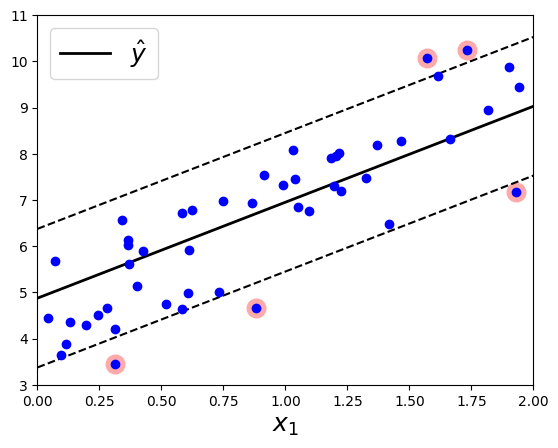

In [15]:
from sklearn.svm import SVR

# First we generate some data
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()


# Set up the regression
svm_reg = SVR(kernel = 'linear', epsilon=1.5)
svm_reg.fit(X, y)

plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])

In the nonlinear case, we can make use of kernel tricks. For example, if we expect our the data we want to fit follows a polynomial relationship, we can use a polynomial kernel. See the example below.

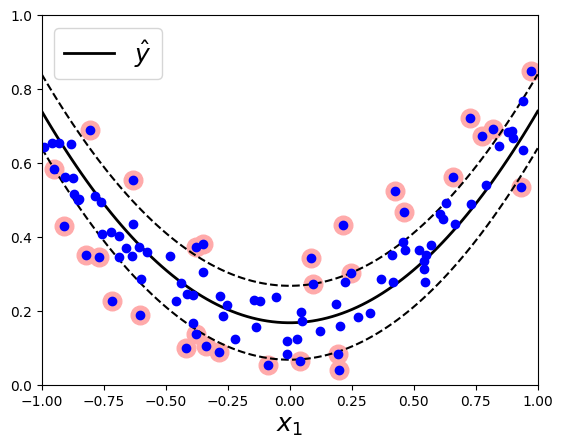

In [16]:
from sklearn.svm import SVR

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])

<div style="background-color:#000">

### Exercise

See how this regression varies with the model hyperparameters, including `epsilon` and `C`. Make sure to plot the results for each parameter value you try.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

<div style="background-color:#000">

# Appendix <a id='appendix'></a>

[Return to Outline](#index)

In this section, you will find longer pieces of mathematics and code which are **non-examinable**. Please read at your own discretion

- A. [Mathematics of SVM Classifiers (SVCs)](#SVM_app)
- B. [Mathematics of Kernel Tricks](#kernel_app)
- C. [A Worked Kernel Trick Example](#kernel_ex_app)
- D. [Mathematics of SVM Regressors (SVRs)](#SVR_app)   
    

<hr style="border:2px solid gray">

<div style="background-color:#000">

## A. Mathematics of SVM Classifiers [^^](#appendix) <a id='SVM_app'></a>

[Return to relevant section in notes](#SVM_intro) 
    
### Defining the Boundary Conditions
    
We will use the dot product form of a hyperplane to define our parameters. We first need to find the two hyperplanes that bound the margin, which we will refer to as $H_1$ and $H_2$. Eventually, we want to find the hyperplane that maximises the margin, $H_0$. We can define these hyperplanes as:

\begin{align*}
H_1: \mathbf{w}^T\mathbf{X} - b &= +1\text{: any points on or above this boundary are in the class with label +1} \\
H_2: \mathbf{w}^T\mathbf{X} - b &= -1\text{: any points on or below this boundary are in the class with label -1} 
\end{align*}
where

* $\mathbf{w}$ and $b$ are the vector and scalar parameters of the hyperplanes respectively
* $X$ is any vector in the $d$-dimensional input space $\mathbb{R}^d$
* $\mathbf{w}^T$ denotes the transpose of the vector $\mathbf{w}$

We will denote the class label of the $i$-th training point as $y_i$ with input $\mathbf{X}_i$, which is defined such that $y_i$ takes values of either $+1$ or $-1$ for all $i$. We can combine the requirements that $y_i = +1$ if it is on or above $H_1$ and $y_i = -1$ if it is on or below $H_2$ into one equation:

\begin{equation*}
y_i\cdot(\mathbf{w}^T\mathbf{X}_i - b)\geq 1, \, \forall i
\end{equation*}

for all training points $\{\mathbf{X_i}, y_i\}$.

### Calculating the margin

To calculate the margin width, we need to find the distance between $H_1$ and $H_2$. To do this, consider some point $\mathbf{X}_0$ in the hyperplane $H_2$ such that
\begin{equation*}
\mathbf{w}^T\mathbf{X}_0 - b = -1
\end{equation*}

We need to find the intersection of a line perpendicular to $H_2$ with $H_1$. We can define the normalised direction vector of this line as $\frac{\mathbf{w}}{|\mathbf{w}|}$, as $\mathbf{w}$ is in general a vector normal to the hyperplane. 

We must step a distance $r$ along this line, where $r$ is the distance between the two hyperplanes, to intersect with $H_1$. We therefore know that $\mathbf{X}_0 + r\frac{\mathbf{w}}{|\mathbf{w}|}$ is a point in $H_1$, so we wish to solve:

\begin{equation*}
\mathbf{w}\left(\mathbf{X}_0 + r\frac{\mathbf{w}}{|\mathbf{w}|}\right) - b = 1
\end{equation*}

We can therefore simplify this equation:

\begin{align*}
& \mathbf{w}\mathbf{X}_0 + r\frac{\mathbf{w}\mathbf{w}}{|\mathbf{w}|} - b = 1 \\
\implies & \mathbf{w}\mathbf{X}_0 + r\frac{|\mathbf{w}|^2}{|\mathbf{w}|} - b = 1 \\
\implies & \mathbf{w}\mathbf{X}_0 + r|\mathbf{w}| - b = 1 \\
\implies & \mathbf{w}\mathbf{X}_0 - b = 1 - r|\mathbf{w}|
\end{align*}

We can then use the fact that $\mathbf{X}_0$ is by definition in $H_2$ and so $\mathbf{w}\mathbf{X}_0 - b = -1$:
\begin{align*}
\implies & -1 = 1-r|\mathbf{w}| \\
\implies & r = \frac{2}{|\mathbf{w}|}
\end{align*}

In order to maximise the margin, we wish to minimise the value of $r$, subject to the constraint that

\begin{equation*}
y_i\cdot(\mathbf{w}^T\mathbf{X}_i - b)\geq 1, \, \forall i
\end{equation*}

This is the hard-margin constraint. In soft-margin classification, we allow for outliers (which we will discuss shortly).

### Defining the minimisation function

Of course, as $r = \frac{2}{|\mathbf{w}|}$, we can re-express our problem not as a maximisation of $r$ but a minimisation of $|\mathbf{w}|$. 

Minimising $|\mathbf{w}|$ is difficult, because it has a discontinuity in its derivative at $\mathbf{0}$. Instead, we can use the fact that $f(x) = x^2$ is a monotonically increasing function for non-negative $x$. As a result, instead of minimising $|\mathbf{w}|$, we can minimise 
\begin{equation*}
\frac{1}{2}|\mathbf{w}|^2
\end{equation*}

We will in general write $|\mathbf{w}|^2$ as $\mathbf{w}^T\mathbf{w}$, such that the derivative of this term with respect to $\mathbf{w}$ is $\mathbf{w}^T$.

As a result, for hard-margin classification, the optimisation problem is completely defined as:

\begin{align*}
\min_{\mathbf{w},\, b}\quad & \frac{1}{2}\mathbf{w}^T\mathbf{w} \\
\text{subject to}\quad & y_i\cdot(\mathbf{w}^\intercal\mathbf{X}_i - b) \geq 1  ,
\end{align*}
where $\min\limits_{\mathbf{w{,\, b}}}$ means that the minimisation is with respect to $\mathbf{w}$ and $b$.

In practice, outliers in our dataset mean it is often difficult to find a hyperplane that perfectly separates the two classes. Instead, we must adopt the soft-margin condition, where we allow margin violations. To do this, we must introduce two new variables:

* $\zeta_i \geq 0$: a Euclidean distance from the $i$-th training point to the hyperplane bordering the correct classification region, scaled by the margin size (i.e. if the distance is $d_i$, $\zeta_i = \frac{d_i}{r}$)
    * If the training point is in the correct region, $\zeta_i = 0$
    * If the training point is within the margin but still in the correct side of the boundary, $0 \lt \zeta_i \lt 1$
    * If the training point is on the wrong side of the boundary, $\zeta_i > 1$
* $C$: the regularisation parameter, which controls how much we penalise margin violations

After introducing these parameters, we can rewrite our optimisation problem as

\begin{align*}
\min_{\mathbf{w},\, b,\, \zeta} \quad & \frac{1}{2} \mathbf{w}^T\mathbf{w} + C\sum_{i = 1}^n\zeta_i \\
\text{subject to} \quad& \begin{cases} & y_i\cdot(\mathbf{w}^\intercal\mathbf{X}_i - b)\geq 1 - \zeta_i, \\
 & \zeta_i \geq 0 \quad \forall\,\, i,\end{cases}
\end{align*}

Low values of $C$ allow greater margin violations, while high values minimise margin violations. For very high values of $C$, this is very similar to the hard-margin classification problem.

### Solving the optimisation problem

We will now only discuss the hard-margin problem for simplicity of mathematics, but the same logic can be applied to the soft margin problem. To solve this problem, we adopt the approach of Lagrange multipliers, which you should have seen before. We so far have formulated the so-called **primal** optimisation problem. We will use Lagrange multipliers to formulate the so-called **dual** problem, which is particularly important for non-linear SVM. 

Our primal form of the optimisation problem is 

\begin{align*}
\min_{\mathbf{w},\, b}\quad & \frac{1}{2}\mathbf{w}^T\mathbf{w} \\
\text{subject to}\quad & y_i\cdot(\mathbf{w}^\intercal\mathbf{X}_i - b) \geq 1.
\end{align*}

This has a corresponding primal Lagrangian, given as

\begin{align*}
\mathcal{L}_p(\mathbf{w}, b, \boldsymbol{\lambda}) &= \frac{1}{2}\mathbf{w}^T\mathbf{w} - \sum_i\lambda_i(y_i(\mathbf{w}^T\mathbf{X}_i + b) - 1) \\
&= \frac{1}{2}\mathbf{w}^T\mathbf{w} - \sum_i\lambda_i(y_i(\mathbf{w}^T\mathbf{X}_i + b)) + \sum_i\lambda_i,
\end{align*}
where $\boldsymbol{\lambda}$ is the vector of Lagrange multipliers $\lambda_i$, where we require that $\lambda_i \geq 0$ for all $i$.

To solve this problem, we want to maximise the Lagrangian with respect to our Lagrange multipliers $\lambda_i$ and minimise it with respect to $\mathbf{w}$ and $b$. We will use the minimisation constraints to formulate the so-called **dual problem**:

The derivatives of $\mathcal{L}_p$ with respect to $\mathbf{w}$ and $b$ are equal to 0, which gives

\begin{align*}
    \frac{\partial \mathcal{L}_p}{\partial \mathbf{w}} &= \mathbf{w}^T - \sum_i \lambda_i y_i \mathbf{X}_i^T =0 
    \implies \mathbf{w} = \sum \lambda_i y_i \mathbf{X}_i, \\
    \frac{\partial \mathcal{L}_p}{\partial b} &= \sum \lambda_i y_i = 0.
\end{align*}

We can substitute these results back into our original Lagrangian to formulate the dual problem:

\begin{align*}
\mathcal{L}_D(\boldsymbol{\lambda}) &= 
\frac{1}{2} (\sum_i \lambda_i y_i \mathbf{X}_i^T)(\sum_j \lambda_j y_j\mathbf{X}_j) -
\sum_i \lambda_i y_i  (\sum_j \lambda_j y_j\mathbf{X}_j^T) \mathbf{X}_i 
-b \sum_i \lambda_i y_i + \sum \lambda_i \\
&= \sum \lambda_i - \frac{1}{2} \sum_i \sum_j \lambda_i \lambda_j y_i y_j \mathbf{X}_i^T \mathbf{X}_j
\end{align*}

Then, we get our final solution by solving the following optimisation problem:

\begin{align*}
    \min_\lambda \quad & \frac{1}{2}\boldsymbol\lambda^\intercal \mathbf{Q} \boldsymbol\lambda - \mathbf{e}^\intercal \boldsymbol\lambda \\
    \text{subject to} \quad & \begin{cases}
        & \mathbf{y}^\intercal\boldsymbol\lambda = 0 \\
        & 0 \leq \alpha_i \leq C \quad \forall\,\, i
    \end{cases}
\end{align*}
where the symbols are defined as follows:
* $\boldsymbol\lambda$ is the vector of Lagrange multipliers ($\lambda_1, \dots, \lambda_n$) and $\lambda_i$ is the Lagrange multiplier for training sample $i$
* $\mathbf{Q}$ is a $n$ by $n$ positive semi-definite matrix, with entries $Q_{ij} = y_i y_j \mathbf{X}^\intercal_i\mathbf{X}_j$
* $\mathbf{e}$ is the vector of all ones (1, $\dots$, 1)

This follows the notation convention of the sklearn [User Guide](https://scikit-learn.org/stable/modules/svm.html) for support vector machines, with the exception of using $\lambda$ to denote Lagrange multipliers instead of $\alpha$.


By solving this optimisation problem, we can subsequently determine $\mathbf{w}$ and $b$. The key thing to note here is that the *only* dependence on the input vectors $\mathbf{X}_i$ and $\mathbf{X}_j$ is through an inner product between them. This is particularly important for the kernel tricks we use in non-linear SVM.

When you work through this optimisation problem, it can be shown that the prediction of a soft-margin classifier for a test point $\mathbf{X}_t$ is given by

\begin{equation*}
\hat{y}_t = \text{sign}\left(\sum_{i\,\in\,\text{SV}}y_i\lambda_i\mathbf{X_i}^T\cdot\mathbf{X}_t + b\right),
\end{equation*}
where the sum is over the **support vectors** and the parameters $\lambda_i$ are determined during the optimisation procedure. Each $\lambda_i$ must be greater than 0 but less than C. The sum is only over support vectors as $\lambda_i$ goes to 0 for all other training points during the optimisation procedure.

<hr style="border:2px solid gray">

<div style="background-color:#000">

## B. Mathematics of Kernel Tricks [^^](#appendix) <a id='kernel_app'></a>

[Return to relevant section in notes](#kernel) 
    
Our data is no longer linear seperable, so we must map our data onto a higher dimension. This mapping function  has the symbol $\phi$. $\phi(\boldsymbol{X})$ is thus a vector in a higher dimension than $\boldsymbol{X}$. The ideal **kernel** is equal to the inner product of two of these mapped vectors, but is only a function of the dot product in the original feature space: $K(\boldsymbol{X}_i, \boldsymbol{X}_j) = ( \phi(\boldsymbol{X}_i) \cdot \phi(\boldsymbol{X}_j) )$
    
Our dual Lagrangian we wish to maximise in this higher dimension can be written as:

\begin{align*}
\mathcal{L}_D(\boldsymbol{a})&= \sum_i\lambda_i - \frac{1}{2} \sum_i \sum_j \lambda_i \lambda_j y_i y_j \phi(\boldsymbol{X}_i)^T \phi(\boldsymbol{X}_j) \\
&= \sum_i\lambda_i - \frac{1}{2} \sum_i \sum_j \lambda_i \lambda_j y_i y_j K(\boldsymbol{X}_i, \boldsymbol{X}_j)
\end{align*}
    
To see how this helps us, we will use the example of the polynomial kernel.

$$ K(\boldsymbol{X},\boldsymbol{X'}) = \phi(\boldsymbol{X})^T\phi(\boldsymbol{X'})  = (1+\boldsymbol{X}^T\boldsymbol{X'})^d$$

for any $d>0$.

This is important. One can see clearly that regardless of how many features we wish to add to the dataset, we only need to know the results of the dot products in the original, lower dimensional space. Thus we can implicitly perform our computations in the higher dimensional space without such a large computational cost. A worked example of this can be seen in the next appendix.
    
For more information on kernel tricks, please see [Berkeley's Lecture Notes](https://people.eecs.berkeley.edu/~jordan/courses/281B-spring04/lectures/lec3.pdf) by Michael I. Jordan or (for even greater depth) [Stanford's Lecture Notes](https://cs229.stanford.edu/lectures-spring2022/main_notes.pdf) by Andrew Ng.

<hr style="border:2px solid gray">

<div style="background-color:#000">
    
## C. A Worked Kernel Trick Example [^^](#appendix) <a id='kernel_ex_app'></a>  
    
[Return to relevant section in notes](#kernel) 

To see how this how kernel tricks help us, we will use work through an example in code using a polynomial kernel.
    
In general, a $d$-order polynomial kernel takes the following form:

$$ K(\boldsymbol{X},\boldsymbol{X'}) = \phi(\boldsymbol{X})^T\phi(\boldsymbol{X'})  = (c+\boldsymbol{X}^T\boldsymbol{X'})^d$$

where $c$ is a non-negative constant.

We will consider an example originally with 2 input features.

In [ ]:
import sklearn, sklearn.datasets

In [ ]:
n_samples=1000
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

svm_2d = SVC(kernel="linear", C=1)
svm_2d.fit(X, Y)


plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

plot_svc(svm_2d, -2, 2, False)

print('Accuracy:',svm_2d.score(X, Y)) 
#This is the mean accuracy of our model. Randomly assigning points should give 0.5

plt.show()


<div style="background-color:#000">
    
 As expected, a traditional SVM model is unable to act as a classifier. We must instead move to a higher dimension. One way to do this is to use the mapping:
\begin{equation}
\phi (\boldsymbol{X}) = \phi \left(\begin{pmatrix} X_{1} \\X_{2} \end{pmatrix}\right) =
    \begin{pmatrix} X_{1}^2 \\ \sqrt{2} X_{1} X_{2} \\ X_{2}^2 \end{pmatrix}
\end{equation}

In [ ]:
X=np.array(X)
X_n_0 = X[:,0]**2
X_n_1 = 2**0.5 * X[:,0] * X[:,1]
X_n_2 = X[:,1]**2
X_n =np.array([X_n_0, X_n_1, X_n_2])
X_n = X_n.transpose()

<div style="background-color:#000">

This transformed data is plotted in 3D below. Feel free to change the viewing angle and point opacity as desired. It does appear that a plane could separate the two data classes.

In [ ]:
ax = plt.axes(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(10, 270)
ax.set_xlim3d(0,5)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(0,6)
ax.scatter3D(X_n_0, X_n_1, X_n_2, c=Y, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

<div style="background-color:#000">

We will fit our newly mapped data using as SVM classifier, again with a linear kernel, and plot the results. 3D plots can be difficult to interpret, so feel free to change the viewing angle, point opacity and how much we have zoomed in on our data.

In [ ]:
svm_3d = SVC(kernel="linear", C=1)
svm_3d.fit(X_n, Y)
print ('Accuracy:',svm_3d.score(X_n, Y)) 

In [ ]:
def plot_svc_3d(svm_clf, xmin, xmax, ymin, ymax, ax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    x_lin = np.linspace(xmin, xmax, 200)
    y_lin = np.linspace(ymin, ymax, 200)
    xx, yy = np.meshgrid(x_lin, y_lin)
    coords = (np.c_[xx.ravel(), yy.ravel()]).transpose()
    
    Z = -w[0]/w[2] * coords[0] - w[1]/w[2] * coords[1] - b/w[2]
    Z[Z < 0] = np.nan
    ax.plot(coords[0], coords[1], Z , "k",  alpha=0.6)
    
    return (Z)


In [ ]:
plt.figure( figsize= (8,8))
ax = plt.axes(projection='3d')
ax.view_init(10, 270)

# To make the final plot clearer, we are not displaying some points
X_n_0[X_n_0 > 1.5]= np.nan
X_n_1[abs(X_n_1) > 1.5]= np.nan
X_n_2[X_n_2 > 1.5]= np.nan

ax.scatter3D(X_n_0, X_n_1, X_n_2, c=Y, cmap=plt.cm.Spectral, alpha=0.3)
Z = plot_svc_3d(svm_3d, 0,1.5, -1.5,1.5, ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d(0,1.5)
ax.set_ylim3d(-1.5,1.5)
ax.set_zlim3d(0,1.5)
plt.show()

<div style="background-color:#000">
    
### The trick
    
In this analysis, we will instead simply calculate the kernel:
\begin{equation}
K(\boldsymbol{X}, \boldsymbol{X'}) = \phi (\boldsymbol{X}) \cdot \phi (\boldsymbol{X'}) = \left (\begin{array}{c} X_{1}^2 \\ \sqrt{2} (X_{1} X_{2}) \\ X_{2}^2 \end{array}\right) 
   \cdot \left (\begin{array}{c} {X'}_{1}^2 \\ \sqrt{2} ({X'}_{1} {X'}_{2}) \\ {X'}_{2}^2 \end{array}\right) \\
    = X_{1}^2 {X'}_{1}^2 + 2 X_{1} X_{2} {X'}_{1} {X'}_{2} + X_{2}^2 {X'}_{2}^2
    = {(X_{1} {X'}_{1} + X_{2} {X'}_{2})}^2 \\
    = {(\boldsymbol{X}^T \boldsymbol{X'})}^2
\end{equation}    
    
This is simply a function of the inner product in a lower dimension.  We could have saved signifcant computational time by computing these untransformed inner products instead. Note this also matches the form of the polynomial kernel we stated early, with $c=0$ and $d=2$ (a polynomial kernel with $c = 0$ is called **homogenous**)

This time, we can try to fit our initial data using an SVM with a polynomial kernel. We will set `coef0 = 0` ($c$ in the equation above) and `degree = 2`.

In [ ]:
svm_ex_poly = SVC(kernel="poly", degree=2, coef0=0, C=1)
svm_ex_poly.fit(X, Y)

plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

plot_predictions(svm_ex_poly, [-2, 2, -2, 2])

plt.axis([-2, 2, -2, 2])
plt.show()
print ('Accuracy:',svm_ex_poly.score(X, Y))

<div style="background-color:#000">


As you can see, we immediately do a better job than the linear kernel, without needing to transform into the higher dimension. While in this example it is simple to transform the data to better separate the classes, in general there may not be an obvious transformation, or we may need to add many features to separate our classes. These situations are where kernels are particularly useful. 

<hr style="border:2px solid gray">

<div style="background-color:#000">
    
## D. Mathematics of SVM Regressors (SVRs) [^^](#appendix) <a id='SVR_app'></a>  
    
[Return to relevant section in notes](#SVR) 
    
_References: sklearn's [documentation](https://scikit-learn.org/stable/modules/svm.html)_
    
We want our predicted model to be **as general as possible**, and so we want to **maximise** the prediction error whilst still maintaining an error ideally less than $\epsilon$. This is different to the regression approaches we have seen before, where we simply wanted to minimise error.
    
This is because in SVR we want to control our model's tolerance for error through a hyperparameter. Maximising the margin while still maintaining our constraint should make our model perform better on unseen data.
    
Therefore this is an extremely similar problem to SVC, except with a different constraint.
    
### Hard-margin SVR
    
A training input $\boldsymbol{X}_i$ has a target value $y_i$. The model predicted value $\hat{y}_i = \boldsymbol{w}^T \boldsymbol{X}_i+b$. We can therefore write our constraint as:

\begin{align*}
& | y_i - y'_i| \le \varepsilon \\
\implies & |y_i - (\boldsymbol{w}^T \boldsymbol{X}_i+b)| \le \varepsilon
\end{align*}
    
We can therefore write our minimisation problem as
\begin{align*}
\min_{\mathbf{w},\,b} \quad & \frac{1}{2} ||\mathbf{w}||^2 \\
\text{subject to} \quad & |y_i - (\boldsymbol{w}^T \boldsymbol{X}_i+b)| \le \varepsilon
\end{align*}
    
### Including Outliers
    
Not every point will be inside the $\varepsilon$ region. We introduce the terms $\xi_i$ to be the distance above the $\varepsilon$-region where a datapoint is not penalised, and $\xi_i^*$ to represent the distance below. See the image in the SVR section to see what this means. If a point is in the region, both values of $\xi_i$ and $\xi_i^*$ will be 0. 
<br></br>

**Please note**: $\xi_i^*$ is **not** the complex conjugate of $\xi_i$, just a different set of variables.
<br></br>

We want to balance these errors with maximising the margin. So our new function we wish to minimise is:
$$\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} + C \sum (\xi_i + \xi_i^*)$$
where C is a hyperparameter that acts in the same way as for SVM.
    
Since we are now allowing points to be outside the region, we also have new constraints:
    
$$ y_i - (\boldsymbol{w}^T \boldsymbol{X}_i+b) \le \epsilon + \xi_i \newline
\boldsymbol{w}^T \boldsymbol{X}_i+b - y_i \le \epsilon + \xi_i^* \newline
\xi_i, \xi_i^* \ge 0$$   
    
We can solve this in the same way we did for SVC, including with the use of kernel tricks. We find we have two sets of Lagrange multipliers corresponding to our two sets of variables, which we label as $\lambda_i$ and $\lambda_i^*$. We can write the optimisation problem as follows:

\begin{align*}
\min_{\boldsymbol\lambda, \boldsymbol\lambda^* } \quad & \frac{1}{2}(\boldsymbol\lambda - \boldsymbol\lambda^* )^\intercal \mathbf{Q}^* (\boldsymbol\lambda - \boldsymbol\lambda^* ) + \varepsilon \mathbf{e}^\intercal(\boldsymbol\lambda + \boldsymbol\lambda^* ) - y^\intercal(\boldsymbol\lambda - \boldsymbol\lambda^* ) \\
\text{subject to} \quad & \begin{cases}
    & \mathbf{e}^\intercal(\boldsymbol\lambda - \boldsymbol\lambda^*) = 0 \\
    & 0 \leq \boldsymbol\alpha_i, \boldsymbol\lambda^*_i \leq C \quad i = 1, \dots, n
\end{cases}
\end{align*}

where the symbols are defined as follows:
* $\boldsymbol\lambda = (\lambda_1, \dots, \lambda_n)$ : the Lagrange multipliers for the $\xi_i$ constraint
* $\boldsymbol\lambda^* = (\lambda^*_1, \dots, \lambda^*_n)$: the Lagrange multipliers for the $\xi^*_i$ constraint
* $\mathbf{Q}^*$ is an $n$ by $n$ positive semidefinite matrix, with entries $Q^*_{ij} = \mathbf{X}_i^\intercal \mathbf{X}_j$. 
* $\mathbf{e}$ is the vector of ones

Again, this follows the same notation as the sklearn [User Guide](https://scikit-learn.org/stable/modules/svm.html), with the exception of denoting the matrix $\mathbf{Q}$ as $\mathbf{Q}^*$ to avoid confusion with the classification formulation, and using $\lambda$ instead of $\alpha$. As before, * does not refer to a complex conjugate. Similarly, $\boldsymbol\lambda^*$ is not the complex conjugate of $\boldsymbol\lambda$ but just denotes a different set of Lagrange multipliers, corresponding to the slack variables $\xi_i^*$.

Finally, after determination of the coefficients $\boldsymbol\lambda$ and $\boldsymbol\lambda^*$ the prediction for test input $\mathbf{X}_t$ is given as

\begin{equation*}
\hat{y}_t = \sum_{i\in\text{SV}}(\lambda_i - \lambda_i^*)\mathbf{X}_i^\intercal\mathbf{X}_t + b
\end{equation*}

where once again the sum is only over the support vectors.